# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys
from helper_fun_model import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

In [53]:
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

# Case 1 Simulate China infection numbers
## Data source
#### source https://github.com/BlankerL/DXY-COVID-19-Data
- Covid infection data of China only
- using this source as previous source is not updating and had only counts till Feb 11
- git clone https://github.com/BlankerL/DXY-COVID-19-Data.git and manually copy csv folder in to this working directory

In [3]:
df_blanker = pd.read_csv("./csv/DXYArea.csv", parse_dates=True)
# df_blanker = pd.read_csv("./csv/DXYArea.csv", parse_dates=True)

In [4]:
df_blanker.shape

(44066, 15)

In [5]:
df_blanker = df_blanker[df_blanker['provinceEnglishName']=='Hubei']

In [6]:
df_blanker.head()

,provinceName,provinceEnglishName,province_zipCode,cityName,cityEnglishName,city_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount,updateTime
43,湖北省,Hubei,420000,武汉,Wuhan,420100.0,59989,0,7887,1789,42752,0,4221,1381,2020-02-18 11:44:23.488
44,湖北省,Hubei,420000,孝感,Xiaogan,420900.0,59989,0,7887,1789,3320,0,523,75,2020-02-18 11:44:23.488
45,湖北省,Hubei,420000,黄冈,Huanggang,421100.0,59989,0,7887,1789,2828,0,941,84,2020-02-18 11:44:23.488
46,湖北省,Hubei,420000,荆州,Jingzhou,421000.0,59989,0,7887,1789,1537,0,339,38,2020-02-18 11:44:23.488
47,湖北省,Hubei,420000,随州,Suizhou,421300.0,59989,0,7887,1789,1278,0,198,25,2020-02-18 11:44:23.488


In [7]:
df_blanker['date'] = df_blanker['updateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())

In [8]:
# Each record is city level counts updated at different timings, therefore we need to first 
# extract each city's max update time
df_daily_max_datetime = df_blanker.groupby(['date','cityName']).agg({'updateTime':'max'}).reset_index()

In [9]:
# then we do a join with the current data on city and on the MAX updatetime
df_daily_max = pd.merge(df_daily_max_datetime, df_blanker, on=['updateTime','date','cityName'], how='inner')

In [10]:
df_daily_max.tail()

,date,cityName,updateTime,provinceName,provinceEnglishName,province_zipCode,cityEnglishName,city_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount
425,2020-02-18,襄阳,2020-02-18 11:44:23.488,湖北省,Hubei,420000,Xiangyang,420600.0,59989,0,7887,1789,1163,0,182,21
426,2020-02-18,鄂州,2020-02-18 11:44:23.488,湖北省,Hubei,420000,Ezhou,420700.0,59989,0,7887,1789,1339,0,265,36
427,2020-02-18,随州,2020-02-18 11:44:23.488,湖北省,Hubei,420000,Suizhou,421300.0,59989,0,7887,1789,1278,0,198,25
428,2020-02-18,黄冈,2020-02-18 11:44:23.488,湖北省,Hubei,420000,Huanggang,421100.0,59989,0,7887,1789,2828,0,941,84
429,2020-02-18,黄石,2020-02-18 11:44:23.488,湖北省,Hubei,420000,Huangshi,420200.0,59989,0,7887,1789,985,0,238,20


In [11]:
covid_cn = df_daily_max.groupby('date').agg({'city_confirmedCount':'sum'}).reset_index()
covid_cn = covid_cn.iloc[:len(covid_cn)-1 ,:] ## remove today's data as it will not be complete
covid_cn.columns = ['date','infected']

In [12]:
covid_cn.shape

(25, 2)

In [13]:
covid_cn['new infected'] = covid_cn['infected'].diff().fillna(1)

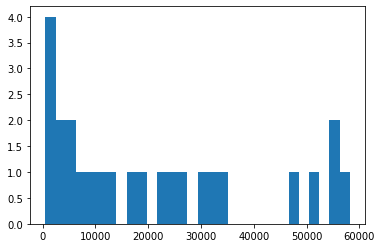

In [14]:
plt.hist(covid_cn['infected'], bins = 30)
plt.show()

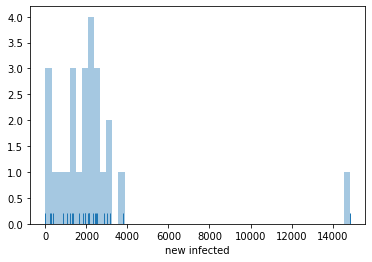

In [15]:
sb.distplot(covid_cn['new infected'], bins=50, kde=False, rug=True);

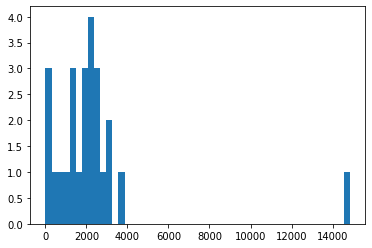

In [16]:
count, gbins, ignored = plt.hist(covid_cn['new infected'], bins=50)

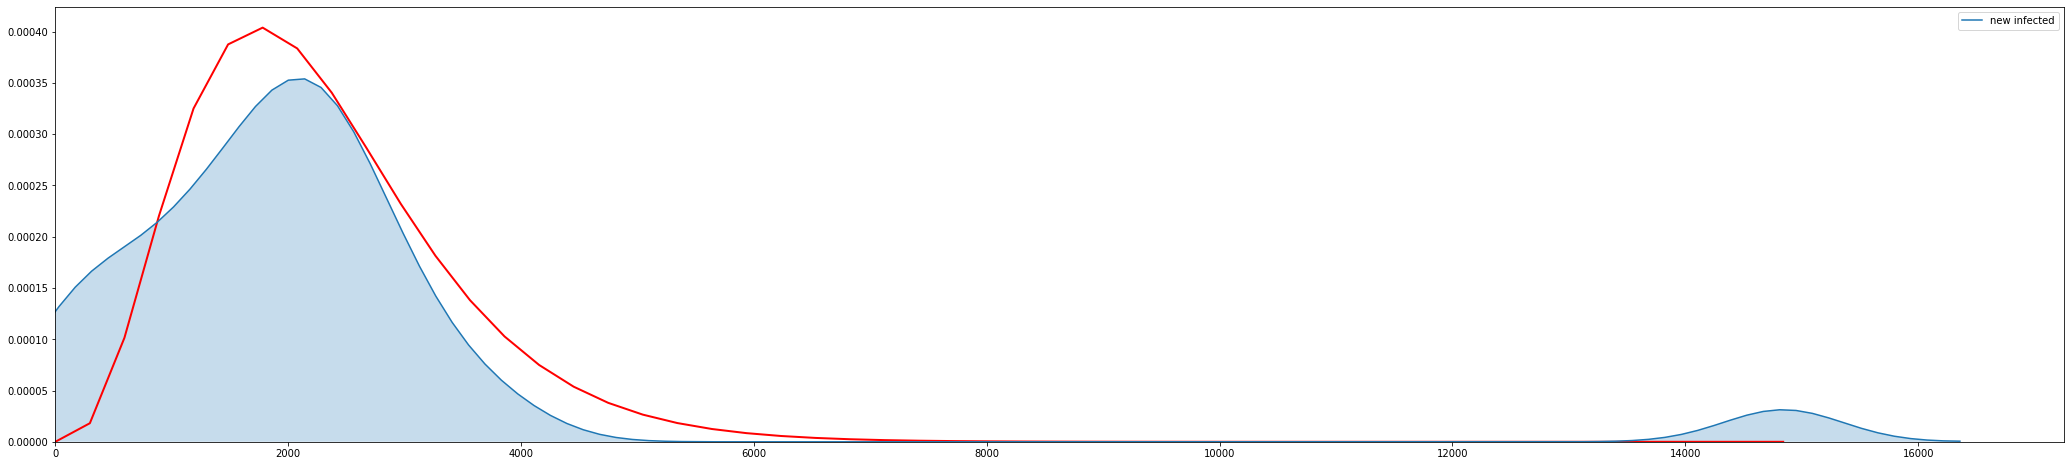

In [17]:
shape, scale = 4.3, 530 # mean=4, std=2*sqrt(2)
import scipy.special as sps
fig = plt.figure(figsize=(36,8))

# gcount, gbins, gignored = plt.hist(data, 200, density=True)
# y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
# plt.plot(gbins, y, linewidth=2, color='r')
# plt.show()

# count, gbins, ignored = plt.hist(covid_cn['new infected'], bins=50)
y = gbins**(shape-1)*(np.exp(-gbins/scale) /(sps.gamma(shape)*scale**shape))
plt.plot(gbins, y, linewidth=2, color='r')
sb.kdeplot(covid_cn['new infected'], shade=True).set(xlim=(0))

plt.show()

# MCMC

In [18]:
mu = covid_cn['new infected'].mean()
sigma = covid_cn['new infected'].std()

In [19]:
mu, sigma

(2305.36, 2786.0695564420735)

In [72]:
# adapted from https://people.duke.edu/~ccc14/sta-663/MCMC.html
from scipy.stats import gamma, norm, lognorm
import copy

def target(theta):
    return gamma.pdf(theta, a=4.3, scale=530)
#     return norm.pdf(theta, loc= 200, scale=100)
def transition(theta1, theta2):
    return lognorm.pdf(abs(theta1-theta2),1)

def mh_covid(niters, mu, sigma):
    theta = mu
    niters = niters
    samples = []
    samples.append(theta)
#     for i in range(1, niters):
    while len(samples) < niters:
        theta_p = theta + np.random.normal(0, sigma)
        if theta_p < 0:
            theta_p = 0
        T_next = target(theta_p)*transition(theta, theta_p) # π(x_cand)q(x(i−1)|x_cand)
        T_prev = target(theta)*transition(theta_p, theta) #   π(x(i−1))q(x_cand|x(i−1))

        a = min(1, max(T_next/T_prev,0))
        u = np.random.uniform()
        if u < a:
            theta = copy.copy(theta_p)
            samples.append(theta)
#     print("Efficiency = %s" %(len(samples)/niters))
#     val = np.sum([s[1] for s in samples])
    val = np.sum(samples)
    print("Mean of samples: %s" %(val/len(samples)))
#     print("Stddev of samples: %s" %(np.std([s[1] for s in samples])))
    print("Stddev of samples: %s" %(np.std(samples)))
    return samples

In [73]:
sampless = [mh_covid(10000, mu, 500) for mu in np.arange(1000, 6000, 1000)]

Mean of samples: 2287.5637907810883
Stddev of samples: 1049.757219689367
Mean of samples: 2256.3984165653555
Stddev of samples: 1041.7410332367851
Mean of samples: 2424.695708706011
Stddev of samples: 1113.5979505249534
Mean of samples: 2373.5403381338783
Stddev of samples: 1109.9720792968367
Mean of samples: 2346.2543388353274
Stddev of samples: 1128.7254316177632


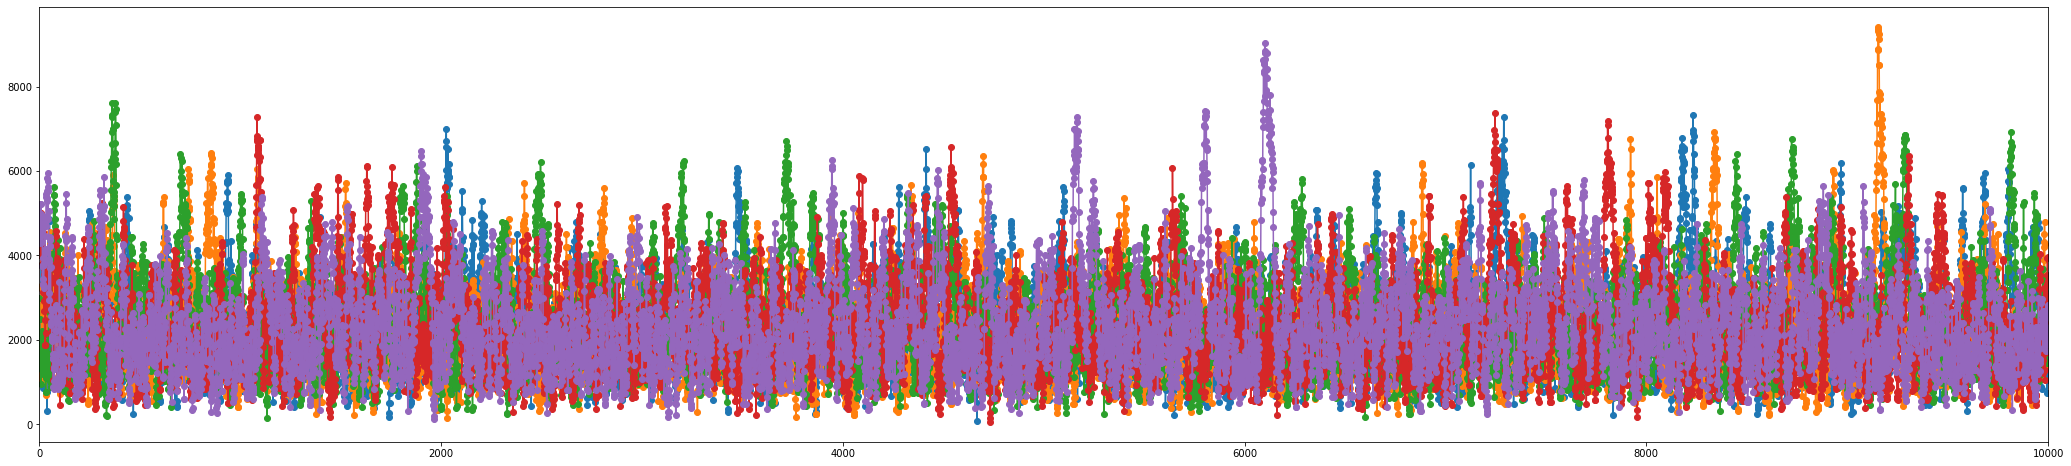

In [74]:
fig = plt.figure(figsize=(36,8))
for samples in sampless:
#     plt.plot([s[0] for s in samples], [s[1] for s in samples], '-o')
    plt.plot(samples, '-o')
plt.xlim([0, 10000])
plt.show()

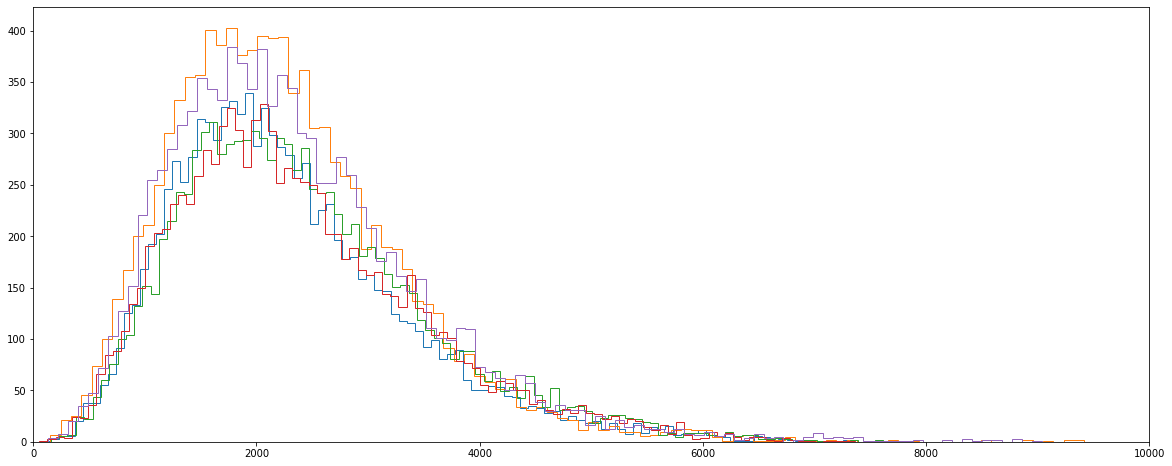

In [76]:
fig = plt.figure(figsize=(20,8))
for samples in sampless:
#     plt.plot([s[0] for s in samples], [s[1] for s in samples], '-o')
    plt.hist(samples, bins=100, histtype='step')
plt.xlim([0, 10000])
plt.show()

In [78]:
# plt.hist([s[1] for s in samples], bins=50)
# plt.show()

In [79]:
# plt.plot([y for x,y in samples], '-o')

## Case 2: Simulate outside China infection numbers

In [36]:
%%time
## Query new data 
! cd ./data_processing && python DXY_AreaData_query.py

2020-02-19 15:11:42Update records successfully to ../data/DXY_Chinese.csv
Save area daily dataset (English) into ../data/DXYArea.csv
Wall time: 15.4 s


In [81]:
df_blanker

,provinceName,provinceEnglishName,province_zipCode,cityName,cityEnglishName,city_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount,updateTime,date
43,湖北省,Hubei,420000,武汉,Wuhan,420100.0,59989,0,7887,1789,42752,0,4221,1381,2020-02-18 11:44:23.488,2020-02-18
44,湖北省,Hubei,420000,孝感,Xiaogan,420900.0,59989,0,7887,1789,3320,0,523,75,2020-02-18 11:44:23.488,2020-02-18
45,湖北省,Hubei,420000,黄冈,Huanggang,421100.0,59989,0,7887,1789,2828,0,941,84,2020-02-18 11:44:23.488,2020-02-18
46,湖北省,Hubei,420000,荆州,Jingzhou,421000.0,59989,0,7887,1789,1537,0,339,38,2020-02-18 11:44:23.488,2020-02-18
47,湖北省,Hubei,420000,随州,Suizhou,421300.0,59989,0,7887,1789,1278,0,198,25,2020-02-18 11:44:23.488,2020-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43777,湖北省,Hubei,420000,孝感,Xiaogan,420900.0,549,0,0,0,22,0,0,0,2020-01-24 09:48:39.253,2020-01-24
43778,湖北省,Hubei,420000,黄冈,Huanggang,421100.0,549,0,0,0,12,0,0,0,2020-01-24 09:48:39.253,2020-01-24
43779,湖北省,Hubei,420000,荆州,Jingzhou,421000.0,549,0,0,0,8,0,0,0,2020-01-24 09:48:39.253,2020-01-24
43780,湖北省,Hubei,420000,武汉,Wuhan,420100.0,549,0,0,0,495,0,0,0,2020-01-24 09:47:38.698,2020-01-24


In [66]:
## Load data 
df_ = pd.read_csv("./csv/DXYArea.csv")

df_qq = pd.read_csv("./csv/qqnews_area.csv")
df.head()

,_id,country,area,city,country_en,area_en,city_en,confirm_count,suspect_count,dead_count,heal_count,confirm_today_count,suspect_today_count,dead_today_count,heal_today_count,sourceLastUpdateTime,query_time
0,1,中国,湖北,武汉,China,Hubei,Wuhan,1590,0,85,44,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0
1,2,中国,湖北,黄冈,China,Hubei,Huanggang,213,0,4,2,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0
2,3,中国,湖北,孝感,China,Hubei,Xiaogan,173,0,1,0,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0
3,4,中国,湖北,荆门,China,Hubei,Jingmen,114,0,3,0,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0
4,5,中国,湖北,恩施州,China,Hubei,Enshi,38,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0


In [67]:
df = df[df['country_en']!='China']

In [68]:
df['date']=df['query_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())

In [69]:
df_daily_max_datetime = df.groupby(['date','country']).agg({'query_time':'max'}).reset_index()

In [70]:
df_daily_max = pd.merge(df_daily_max_datetime, df, on=['date','country','query_time'], how='inner')

In [71]:
df_daily_max[df_daily_max['country_en']=='Singapore']

,date,country,query_time,_id,area,city,country_en,area_en,city_en,confirm_count,suspect_count,dead_count,heal_count,confirm_today_count,suspect_today_count,dead_today_count,heal_today_count,sourceLastUpdateTime
4,2020-01-28,新加坡,2020-01-28 18:00:03.0,218,NaN,NaN,Singapore,NaN,NaN,7,0,0,0,NaN,NaN,NaN,NaN,NaN
17,2020-01-29,新加坡,2020-01-29 23:30:01.0,7386,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN
34,2020-01-30,新加坡,2020-01-30 23:30:02.0,25372,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN
52,2020-01-31,新加坡,2020-01-31 23:30:02.0,43612,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN
78,2020-02-01,新加坡,2020-02-01 17:30:02.0,62586,NaN,NaN,Singapore,NaN,NaN,18,0,0,0,0.0,0.0,0.0,0.0,2020-02-01 15:39:04.0
79,2020-02-01,新加坡,2020-02-01 17:30:02.0,62732,NaN,NaN,Singapore,NaN,NaN,18,0,0,0,0.0,0.0,0.0,0.0,2020-02-01 15:39:04.0
115,2020-02-06,新加坡,2020-02-06 08:44:25.0,70224,NaN,NaN,Singapore,NaN,NaN,28,0,0,1,0.0,0.0,0.0,0.0,2020-02-06 08:42:07.0
139,2020-02-07,新加坡,2020-02-07 15:07:31.0,82277,NaN,NaN,Singapore,NaN,NaN,33,0,0,2,0.0,0.0,0.0,0.0,2020-02-07 14:17:40.0
163,2020-02-08,新加坡,2020-02-08 23:00:04.0,91771,NaN,NaN,Singapore,NaN,NaN,40,0,0,2,0.0,0.0,0.0,0.0,2020-02-08 22:40:04.0
187,2020-02-10,新加坡,2020-02-10 23:30:03.0,111740,NaN,NaN,Singapore,NaN,NaN,45,0,0,7,0.0,0.0,0.0,0.0,2020-02-10 22:31:41.0


In [80]:
df[df['country_en']=='Singapore']

,_id,country,area,city,country_en,area_en,city_en,confirm_count,suspect_count,dead_count,heal_count,confirm_today_count,suspect_today_count,dead_today_count,heal_today_count,sourceLastUpdateTime,query_time,date
217,218,新加坡,NaN,NaN,Singapore,NaN,NaN,7,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-28 18:00:03.0,2020-01-28
556,557,新加坡,NaN,NaN,Singapore,NaN,NaN,7,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 00:19:55.0,2020-01-29
895,896,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 15:19:08.0,2020-01-29
1255,1256,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 15:30:01.0,2020-01-29
1615,1616,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 16:00:03.0,2020-01-29
1975,1976,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 16:04:20.0,2020-01-29
2335,2336,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 16:30:02.0,2020-01-29
2695,2696,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 17:00:02.0,2020-01-29
3055,3056,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 17:30:01.0,2020-01-29
3415,3416,新加坡,NaN,NaN,Singapore,NaN,NaN,10,0,0,0,NaN,NaN,NaN,NaN,NaN,2020-01-29 18:00:01.0,2020-01-29


## References

In [ ]:
import copy

prev_draw = np.random.normal(mu,sigma) #Initialize x(0) ∼ q(x)
sample = []
steps = 1000

for i in range(1, steps):
    if i == 0:
        prev_draw = copy.copy(mu)
    else:
        current = np.random.normal(mu,sigma)
        candidate = transition_model(current, prev_draw) #Propose: x_cand ∼ q(x(i)|x(i−1))
        print("%s, current: %s candidate: %s" %(i,current,candidate))
        T_next = target_model(candidate) # π(x_cand)q(x(i−1)|x_cand)
        T_prev = target_model(current) #   π(x(i−1))q(x_cand|x(i−1))
        a = min(1, max(T_next / T_prev,0)) # Acceptance Probability

        if a > np.random.uniform(0, 1): # u ∼ Uniform (u; 0, 1)
            # Update state
            print("accepted, current: %s candidate: %s" %(current,candidate))
            current = copy.copy(candidate) # Accept the proposal: x(i) ← x_cand
            sample.append(current)
print('Accept ratio:', float(len(sample)) / steps)

In [ ]:
# P(x) : Target distribution
def P(x1, x2, b):
    return np.exp(-0.5 * (x1**2 - 2*b*x1*x2 + x2**2))


# Q(x) : Proposal distribution
def Q(c, mu1, mu2, sigma):
    return (c[0] * np.random.normal(mu1, sigma), c[1] * np.random.normal(mu2, sigma))

def metropolisHastings(mu, sigma):
    current = (10, 10)
    sample = []
    sample.append(current)
    accept_ratio = []

    for i in range(N):
        candidate = Q(current, mu1, mu2, sigma)

        T_prev = P(current[0], current[1], b)
        T_next = P(candidate[0], candidate[1], b)
        a = T_next / T_prev

        if a > 1 or a > np.random.uniform(0, 1):
            # Update state
            current = copy.copy(candidate)
            sample.append(current)
            accept_ratio.append(i)

    print('Accept ratio:', float(len(accept_ratio)) / N)
    return np.array(sample)